### Dataset Visualizations

Dataset used: [Metro dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

##### Features:
* holiday: US National Holiday + Minnesota State Holiday
* temp: average Temperature in Kelvin
* rain_1h: mm or Rain
* snow_1h: mm of Snow
* clouds_all: percentage of cloud cover
* weather_main: short text descr. of weather
* weather_description: longer text descr. of weather
* date_time: datetime
* traffic_volume: westbound Traffic Volume (Ground Truth)

In [2]:
# All imports needed
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor

import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
# Read data from file
metro = pd.read_csv("../data/metro/metro.csv")
metro.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,weekday,hour,good_weather
0,0,288.28,0,0,40,5545,1,9,1
1,0,289.36,0,0,75,4516,1,10,1
2,0,289.58,0,0,90,4767,1,11,1
3,0,290.13,0,0,90,5026,1,12,1
4,0,291.14,0,0,75,4918,1,13,1


In [ ]:
# metro.hist()

#### Modeling:

In [4]:
def linear_reg(train, test):    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    model = LinearRegression()
    model.fit(x_train, y_train)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = model.predict(x_test)
    
    return [y_test, y_pred]

In [72]:
def poly_reg(train, test, deg):    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    poly = PolynomialFeatures(deg)
    x_poly = poly.fit_transform(x_train)
    
    model = LinearRegression()
    model.fit(x_poly, y_train)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = model.predict(poly.fit_transform(x_test))
    
    return [y_test, y_pred]

In [73]:
def knn_reg(train, test, params, score):   
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']

    if score=='mse':
        scoring = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)
    else:
        scoring = metrics.make_scorer(metrics.r2_score)

    model = neighbors.KNeighborsRegressor(1)
    search_obj = GridSearchCV(model, params, scoring)

    fit_obj = search_obj.fit(x_train, y_train)
    best_model = fit_obj.best_estimator_

    print(best_model)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = best_model.predict(x_test)
    
    best = best_model.n_neighbors
    return [y_test, y_pred], best

In [74]:
def reg_tree(train, test, params, score):    
    # Training Model
    x_train = train.drop('traffic_volume', axis=1)
    y_train = train['traffic_volume']
    
    
    if score=='mse':
        scoring = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)
    else:
        scoring = metrics.make_scorer(metrics.r2_score)

    model = DecisionTreeRegressor(random_state=1)
    search_obj = GridSearchCV(model, params, scoring)

    fit_obj = search_obj.fit(x_train, y_train)
    best_model = fit_obj.best_estimator_

    print(best_model)

    # Testing
    x_test = test.drop('traffic_volume', axis=1)
    y_test = test['traffic_volume']
    y_pred = best_model.predict(x_test)

    best = [best_model.max_depth, 
            best_model.min_samples_split, 
            best_model.min_samples_leaf]
    
    return [y_test, y_pred], best

In [75]:
def get_scores(y):
    y_true = y[0]
    y_pred = y[1]
    mse = metrics.mean_squared_error(y_true,y_pred)
    r2 = metrics.r2_score(y_true,y_pred) * 100
    
    return mse, r2

In [76]:
def plot(data, data_s, reg):
    fig = plt.figure(figsize=[8, 4])
    format_string = '{}:\n mse: {:.2f}\n r^2: {:.2f}'
    format_string = '{}:\n mse: {}\n r^2: {}'
    
    datas = [data, data_s]
    strs = [reg, reg + ' scaled']
    
    for i, d in enumerate(datas):
        mse, r2 = get_scores(d)
        ax = fig.add_subplot(1,2,i+1)
        ax.scatter(d[0], d[1])
        ax.set_title(format_string.format(strs[i], mse, r2))
        ax.set_aspect('equal')
        plt.xticks(())
        plt.yticks(())

    plt.savefig('../data/metro/'+ reg +'.png')
    plt.show()

In [77]:
# split
train, test = train_test_split(metro, test_size=0.2)

# scale train
train_s = train.copy()
cols = ['temp', 'clouds_all', 'weekday', 'hour']
scaler = MinMaxScaler()
train_s[cols] = scaler.fit_transform(train_s[cols])

# scale test
test_s = test.copy()
test_s[cols] = scaler.transform(test_s[cols])

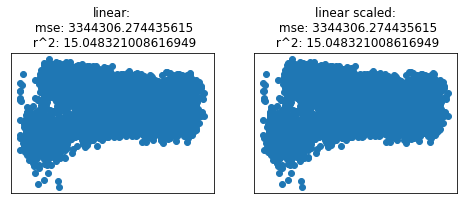

In [78]:
# linear regression

linear = linear_reg(train, test)
linear_s = linear_reg(train_s, test_s)

plot(linear, linear_s, 'linear')

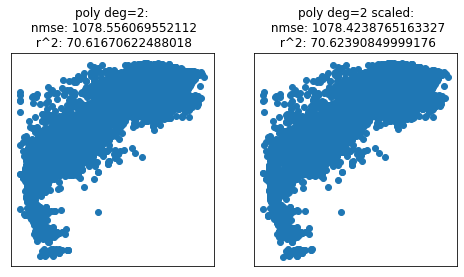

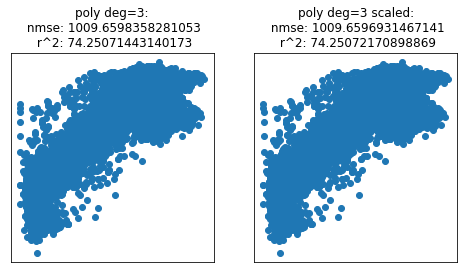

In [24]:
# poly regression

deg=2
poly = poly_reg(train, test, deg)
poly_s = poly_reg(train_s, test_s, deg)
plot(poly, poly_s, 'poly deg='+str(deg))

deg=3
poly = poly_reg(train, test, deg)
poly_s = poly_reg(train_s, test_s, deg)
plot(poly, poly_s, 'poly deg='+str(deg))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


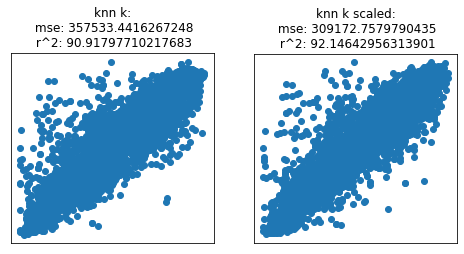

In [79]:
# knn regression
params = {'n_neighbors':[3,5]}

knn, k = knn_reg(train, test, params, 'mse')
knn_s, k_s = knn_reg(train_s, test_s, params, 'mse')
plot(knn, knn_s, 'knn k')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')
tree: max_depth=12, min_samples_split=50, min_samples_leaf=20
mse:266007.365686806
r293.24291183737871
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1, splitter='best')
tree: max_depth=12, min_samples_split=50, min_samples_leaf=20
mse:266007.365686806
r2:93.242911837378

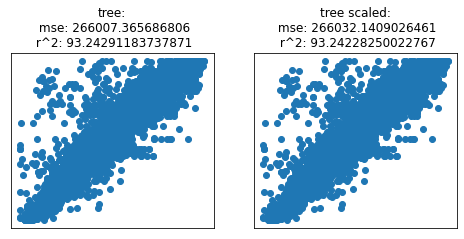

In [80]:
# regression trees

#md 9 - 15 - 15
#mss 140 - 2 - 100
#msl 35 - 2 - 20

params = {'random_state': [1],
          'max_depth': [9, 12, 15],
          'min_samples_split': [2, 50, 100, 140],
          'min_samples_leaf': [2, 10, 20, 35]
         }

tree, v = reg_tree(train, test, params, 'mse')
mse, r2 = get_scores(tree)
print('tree: max_depth={}, min_samples_split={}, min_samples_leaf={}'.format(v[0], v[1], v[2]))
print('mse:'+str(mse))
print('r2'+str(r2))


tree_s, v_s = reg_tree(train_s, test_s, params, 'mse')
mse, r2 = get_scores(tree)
print('tree: max_depth={}, min_samples_split={}, min_samples_leaf={}'.format(v_s[0], v_s[1], v_s[2]))
print('mse:'+str(mse))
print('r2:'+str(r2))


plot(tree, tree_s, 'tree')